# General Analysis - Magnetic Rayleigh-Taylor Instability

### Toward a full analysis of MRT instability (This includes Hall Effects) - Simple Plasma class for caclualting the relevant parameters


'J.D. Huba, Rayleigh-Taylor Instability: Comparison of Hybrid and Nonideal MHD simulation, 1998'

'R. K. Bera, Yang Song, The effect of viscosity and resistivity on Rayleigh-Taylor instability induced mixing in magnetised HEDP, 2021'

'F.R.S. Taylor, The instability of liquid surfaces when accelerated in a direction perpendicular to their planes, 1949'

In [90]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cons
import matplotlib.gridspec as gridspec
from IPython.display import display, Latex

from scipy.interpolate import CubicSpline

# Class: Plasma


In [112]:
class plasma:
    def __init__(self, A, ne, Te, Ti, V, L, Atw, Zsrc, B):
        '''
        Args:
            example:
            ---------------------------------------------------------------------------------------
            al_flow = {'A':27, 'ne': 6.8e18, 'Te': Te, 'Ti': Ti, 'V':4e6, 'L':0.2, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}
            al=Plasma(**al_flow)
            ---------------------------------------------------------------------------------------
            A:      ion mass in nucleon masses
            Te      electron temperature in eV
            V:      velocity in cm/s
            L:      length scale shock in cm.
            Atw:    Atwood Number
            Zsrc:   Charge State Model source, 'exp' or 'FLY'
            B:      Magnetic Field [Tesla]

        '''
        self.A      =   A
        self.ne     =   ne
        self.Te     =   Te
        self.Ti     =   Ti
        self.V      =   V
        self.L      =   L
        self.Atw    =   Atw
        self.Zsrc   =   Zsrc
        self.B      =   B    

        # Estimate Ionisation Charge State - Z - from Tabled Values
        Z_mod = self.ZTe()
        self.Z = Z_mod(self.Te)
        # Calculate Plasma Parameters
        self.params()
        # Calculate MRT Parameters
        self.MRTparams()

    def ZTe(self):
        """
          Function to return ZTe relation from ionisation state tables
        """
        A = self.A
        source = self.Zsrc
        # source = 'FLY'
        if A == 27:     # Aluminium
            if source == 'FLY':
                T_e, Z =  np.genfromtxt('./IonisationTables/Al_Z_1e18.txt', delimiter = '  ', usecols = [0,1], unpack = True)
            else:
                T_e, Z =  np.genfromtxt('./IonisationTables/zb_Al.dat', delimiter=' ', skip_header=2, usecols = [0,3], unpack = True)
        
            Z_mod = CubicSpline(T_e, Z)
            return Z_mod
        if A == 64:     # Copper
            if source == 'FLY':
                T_e, Z = np.genfromtxt('./IonisationTables/Cu_Z_1e18.txt', delimiter='  ', usecols = [0,1], unpack = True)
            else:
                T_e, Z = np.genfromtxt('./IonisationTables/zb_Cu.dat', delimiter='     ', skip_header=2, usecols = [0,2], unpack = True)
            Z_mod = CubicSpline(T_e, Z)
            return Z_mod
        if A == 108:    # Silver
            if source == 'FLY':
                T_e, Z = np.genfromtxt('./IonisationTables/Ag_Z_1e18.txt', delimiter='  ', usecols = [0,1],unpack = True)
            else:
                print("No data available for A:",A)
            Z_mod = CubicSpline(T_e, Z)
            return Z_mod
        if A == 183:    # Tungsten
            if source == 'FLY':
                T_e, Z = np.genfromtxt('./IonisationTables/W_Z_1e18.txt', delimiter='  ', usecols = [0,1],unpack = True)
            else:
                T_e, Z = np.genfromtxt('./IonisationTables/zb_W.dat', delimiter=' ', usecols = [0,1],unpack = True)
            Z_mod = CubicSpline(T_e, Z)
            return Z_mod
        else:
            print("No data available for A:", A)

    def params(self):
        """
        Primary Plasma Parameters

        """
        # Scientific Constant
        m_e         =      cons.m_e           # Electron Mass
        m_i         =      self.A*cons.m_u         # Ion Mass
        e           =      cons.e             # Elemental Charge
        mu_0        =      cons.mu_0          # Vacuum Permeability
        epsilon_0   =      cons.epsilon_0     # Vacuum Permittivity
        kb          =      cons.k             # Boltzmann Constant
        c           =      cons.c             # Light Speed
        
        # Calculate Coulomb Log
        self.CoulombLog()
        
        # Acceleration
        self.a      =    self.V**2/self.L                           # Acceleration [cm s^-2]

        # Velocities
        T_e         =   self.Te*e/kb                               # Electron Temperature [K]
        T_i         =   self.Ti*e/kb                               # Ion Temperature [K]
        n_i         =   self.ne/self.Z
        B           =   np.abs(self.B)

        self.V_te   =   np.sqrt(kb*T_e/m_e)                         # Electron Thermal Speed
        self.V_ti   =   np.sqrt(kb*T_i/m_i)                         # Ion Thermal Speed
        self.V_S    =   np.sqrt(kb*(self.Z*T_e+T_i)/m_i)            # Sound Speed
        self.V_A    =   np.sqrt(B**2/(mu_0*n_i*m_i))                # Alfven Speed

        # Frequency
        n_e         =   self.ne
        n_i         =   n_e/self.Z
        B           =   np.abs(self.B)

        self.om_ce  =   e*B/m_e                                                         # Electron Cyclotron frequency
        self.om_ci  =   self.Z*e*B/m_i                                                  # Ion Cyclotron frequency
        self.om_pe  =   np.sqrt(e**2*n_e/(epsilon_0*m_e))                               # Electron Plasma Frequency
        self.om_pi  =   np.sqrt(self.Z**2*e**2*n_i/(epsilon_0*m_i))                     # Ion Plasma Frequency

        # Collision Frequency
        n_i         =    n_e/self.Z
        self.nu_ei  =    2.91e-6*self.Z*self.ne*self.col_log_ei*self.Te**-1.5                         # Collision Frequency: Electrons - Ions
        self.nu_ie  =    4.80e-8*self.Z**4*self.A**-0.5*n_i*self.col_log_ei*self.Ti**-1.5             # Collision Frequency: Ions - Electrons

        #length scales
        T_e             =    self.Te*e/kb
        T_i             =    self.Ti*e/kb
        n_e             =    self.ne * 1e6

        self.la_de      =    np.sqrt(epsilon_0*kb*T_e/(n_e*e**2))           # Debye length  [cm]      
        self.delta_i    =    c/self.om_pi                                   # ion inertial length (ion skin depth)  [cm]
        self.delta_e    =    c/self.om_pe                                   # electron inertial length (electron skin depth) [cm]
        self.rho_i      =    self.V_ti/self.om_ci                           # Ion Larmor Radius       [cm]
        self.rho_e      =    self.V_te/self.om_ce                           # Electron Larmor Radius  [cm]
        self.mfp_i      =    self.V_ti/self.nu_ie                           # ion mean-free-path      [cm]
        self.mfp_e      =    self.V_te/self.nu_ei                           # electron mean-free-path [cm]

        # Resistivity
        n_e         =    self.ne * 1e6                                                  # Electron Density     [m-3]
        self.sigma  =    n_e*e**2/(m_e*self.nu_ei)                                      # Conductivity         [s kg^-3 m^-3 C^-3]
        self.Dm     =    1/(self.sigma*mu_0)                                            # Magnetic Diffusivity [m^2 s^-1]
        self.eta    =    self.Dm*mu_0                                                   # Resistivity          [s kg^-3 m^-3 C^-3]^-1
        self.Dm     =    self.Dm*1e4                                                    # conversion           [m^2 s^-1] --> [cm^2 s^-1]

        # Pressures
        B           =    np.abs(self.B)
        n_i         =    n_e/self.Z
        V           =    self.V*1e-2                                         # Bulk Speed [cm/s] --> [m/s]
        T_e         =    self.Te*e/kb
        T_i         =    self.Ti*e/kb

        self.P_B    =     B**2/(2*mu_0)
        self.P_th   =     n_i*kb*(self.Z*T_e+T_i)
        self.P_ram  =     n_i*m_i*V**2

    def CoulombLog(self):
        # Couloumb log - NRL
        # ----------------------------------------------------
        self.col_log_ei = 23-np.log(self.ne**0.5*self.Z*self.Te**-1.5)                           #see NRL formulary pg 34

    def printParams(self):

        #useful function tht really should be built in....rounds to n sig figs
        round_to_n = lambda x, n: round(x, -int(np.floor(np.log10(np.abs(x)))) + (n - 1)) 
        
        # Create print list
        ioninertiallength   =    'Ion Inertial Length      =    '   +  str(np.format_float_scientific(self.delta_i, precision = 1, exp_digits=2))   + ' [cm]'
        ionlarmorradius     =    'Ion Larmor Radius        =    '   +  str(np.format_float_scientific(self.rho_i, precision = 1, exp_digits=2))     + ' [cm]'
        ionplasmafrequency  =    'Ion Plasma Frequency     =    '   +  str(np.format_float_scientific(self.om_pi, precision = 1, exp_digits=2))     + ' [rad s^-1]'
        electrontemperature =    'Electron Temperature     =    '   +  str(np.format_float_scientific(self.Te, precision = 1, exp_digits=2))        + ' [eV]'
        iontemperature      =    'Ion Temperature          =    '   +  str(np.format_float_scientific(self.Ti, precision = 1, exp_digits=2))        + ' [eV]'
        chargestate         =    'Charge State - Z         =    '   +  str(self.Z)

        txtstr              =    ioninertiallength + '\n' + ionlarmorradius + '\n' + ionplasmafrequency + '\n' + electrontemperature + '\n' + iontemperature + '\n' + chargestate
        print(txtstr)

    def MRTparams(self):
        # calculate Wave Number
        self.k      =    ((self.Atw*self.a)**(1/3))*(self.Dm)**(-2/3)      
        # Calculate Wavelength
        self.lmax   =    2*np.pi/(self.k)             # maximum lambda max in cm
        # Calculate Growth rate
        self.gr     =    (self.Atw*self.a*self.k)**0.5     # maximum growth rate in 1/s
        # Calculate Tau
        self.tau    =    (1/self.gr)*1e9          # maximum growth time in ns

# Plasma Parameter

## <h1> Ion Plasma Frequency: <center>    $\omega_{pi} = { ({Z^2 e^2 n_i}/{\epsilon_{0} m_i}) }^{1/2} $  </center>      </h1>

## <h1>Ion Inertial Length:   <center>    $\delta_i = {c}/{\omega_{pi}} $    cm </center>       </h1>



In [113]:
Te = 15

al_flow = {'A':27, 'ne': 6.8e18, 'Te': Te , 'Ti': Te, 'V':3e5,  'L':0.2, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}
w_flow  = {'A':183,'ne': 1e18,   'Te': Te , 'Ti': Te, 'V':4e5,  'L':0.2, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}

al  =   plasma(**al_flow)
w   =   plasma(**w_flow)

print('Electron Mass            =    '                              + np.format_float_scientific(cons.m_e, precision = 1, exp_digits=2))           # Electron Mass
print('Ion Mass                 =    '                              + np.format_float_scientific(27*cons.m_u, precision = 1, exp_digits=2))        # Ion Mass
print('Elemental Charge         =    '                              + np.format_float_scientific(cons.e, precision = 1, exp_digits=2))             # Elemental Charge
print('Vacuum Permeability, \N{greek small letter mu}   =    '      + np.format_float_scientific(cons.mu_0, precision = 1, exp_digits=2))          # Vacuum Permeability
print('Vacuum Permittivity, \N{greek small letter epsilon}   =    ' + np.format_float_scientific(cons.epsilon_0, precision = 1, exp_digits=2))     # Vacuum Permittivity
print('Light Speed, c           =    '                              + np.format_float_scientific(cons.c, precision = 1, exp_digits=2))             # Light Speed
print('Boltzmann Constant, kb   =    '                              + np.format_float_scientific(cons.k, precision = 1, exp_digits=2) + "\n")      # Boltzmann Constant

al.printParams()
# w.printParams()

Electron Mass            =    9.1e-31
Ion Mass                 =    4.5e-26
Elemental Charge         =    1.6e-19
Vacuum Permeability, μ   =    1.3e-06
Vacuum Permittivity, ε   =    8.9e-12
Light Speed, c           =    3.e+08
Boltzmann Constant, kb   =    1.4e-23

Ion Inertial Length      =    2.3e-01 [cm]
Ion Larmor Radius        =    1.0e-04 [cm]
Ion Plasma Frequency     =    1.3e+09 [rad s^-1]
Electron Temperature     =    1.5e+01 [eV]
Ion Temperature          =    1.5e+01 [eV]
Charge State - Z         =    4.011461362469553


# Z (Charge State) - Electron Temperature Relation ($n_e$ ~ 1 x $10^{18}$ $cm^{-3}$)

Used experimental values from Thompson Scattering module

File available only for Al, Cu, W

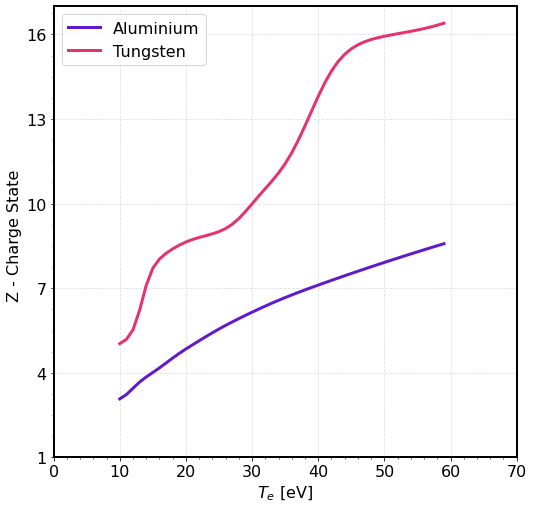

In [93]:
# DEFINE PLASMA
# -------------------------------------------------------------------------------------
Te      =    np.arange(10,60)       # electron temperature eV

al_flow = {'A':27, 'ne': 6.8e18, 'Te': Te , 'Ti': Te, 'V':3e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}
w_flow  = {'A':183,'ne': 1e18,   'Te': Te , 'Ti': Te, 'V':4e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}

al  =   plasma(**al_flow)
w   =   plasma(**w_flow)

# PRETTY PLOT
# --------------------------------------------------------------------------------------

fig = plt.figure(figsize=(8.3,8.3))
ax0 = fig.add_subplot()

for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(2)

ax0.plot(Te, al.Z, lw = '3', color = '#611ACA',label='Aluminium')
ax0.plot(Te, w.Z,  lw = '3', color = '#E53271',label='Tungsten')


ax0.set_ylim([1,17])
ax0.set_xlim([0,70])
ax0.set_xticks(np.arange(0,71,10))
ax0.set_yticks(np.arange(1,17,3))

# Plot Properties
ax0.tick_params(labelsize=16)
ax0.grid(True, linestyle='--', alpha = 0.4)

ax0.set_xlabel(r'$T_e$ [eV]', fontsize=16)
ax0.set_ylabel(r'Z - Charge State ', fontsize=16)
ax0.minorticks_on()
ax0.legend(loc = 'best', fontsize = 16)

# Analisys: Ion Plasma Frequency

Text(0, 0.5, 'Ion Larmour Radius  [cm]')

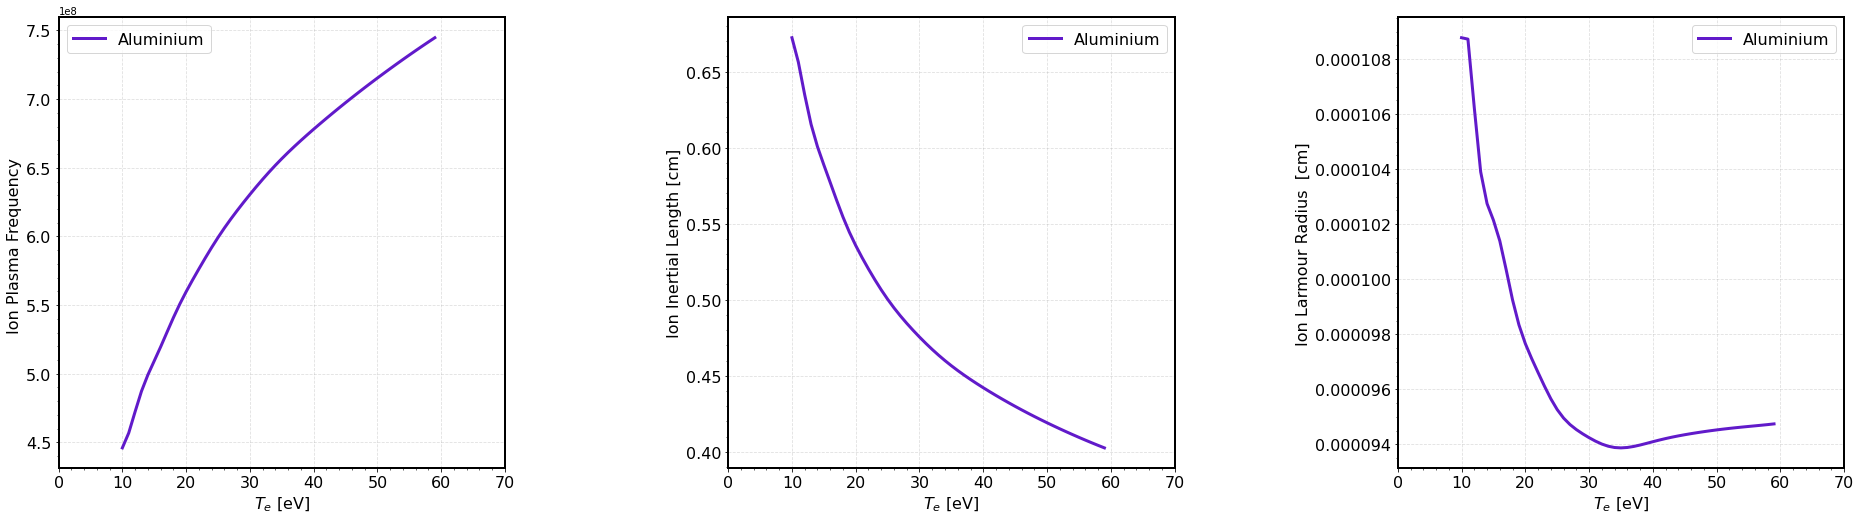

In [97]:
# DEFINE PLASMA
# -------------------------------------------------------------------------------------
Te      =    np.arange(10,60)       # electron temperature eV

al_flow = {'A':27, 'ne': 6.8e18, 'Te': Te , 'Ti': Te, 'V':3e6,  'L':0.2, 'Atw': 1, 'Zsrc': 'exp', 'B': 5}
al  =   plasma(**al_flow)

# PRETTY PLOT
# --------------------------------------------------------------------------------------
fig = plt.figure(figsize=(32,8.3))
gs  = fig.add_gridspec(ncols=3, nrows=1,hspace=0,wspace=0.5)
ax  = gs.subplots()

for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_linewidth(2)
    ax[2].spines[axis].set_linewidth(2)

ax[0].plot(Te, al.om_pi, lw = '3', color = '#611ACA',label='Aluminium')
ax[1].plot(Te, al.delta_i, lw = '3', color = '#611ACA',label='Aluminium')
ax[2].plot(Te, al.rho_i, lw = '3', color = '#611ACA',label='Aluminium')

for axis in ax:
    axis.set_xlim([0,70])
    axis.set_xticks(np.arange(0,71,10))
    axis.tick_params(labelsize=16)
    axis.grid(True, linestyle='--', alpha = 0.4)
    axis.set_xlabel(r'$T_e$ [eV]', fontsize=16)
    axis.minorticks_on()
    axis.legend(loc = 'best', fontsize = 16)

ax[0].set_ylabel(r'Ion Plasma Frequency ', fontsize=16)
ax[1].set_ylabel(r'Ion Inertial Length [cm]', fontsize=16)
ax[2].set_ylabel(r'Ion Larmour Radius  [cm]', fontsize=16)

